<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/StockPrediction/blob/main/Capstone_Microsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
#Standard Practices

import pandas as pd
import datetime
import matplotlib.pyplot as plt

#YahooFinance
import yfinance as yf

#Statsmodels
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot


In [43]:
# Importing the dataset

symbol = 'GOOG'

df = yf.download(symbol, period="max", interval="1d")
df.to_csv("GOOG.csv")

[*********************100%***********************]  1 of 1 completed


In [44]:
df = pd.read_csv("GOOG.csv")
df = df[2:]
df = df.reset_index()
df = df.drop(columns=["index"])
df = df.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
df[columns_to_convert] = df[columns_to_convert].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df['Volume'] = df['Volume'].astype(int)
df.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745408,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5186 non-null   datetime64[ns]
 1   Close   5186 non-null   float64       
 2   High    5186 non-null   float64       
 3   Low     5186 non-null   float64       
 4   Open    5186 non-null   float64       
 5   Volume  5186 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 243.2 KB


In [46]:
df = df[df['Date']>=datetime.datetime(2020,1,1)].reset_index().drop(columns=["index"])
df = df[df['Date']<datetime.datetime(2025,1,31)]

### EDA

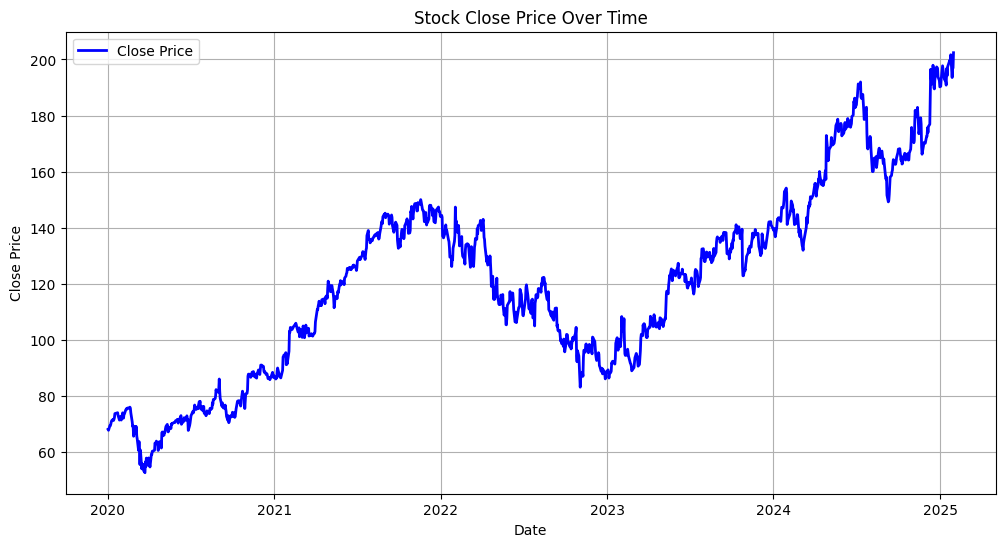

In [47]:
# Plot the Close price
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], color="blue", linewidth=2, label="Close Price")

# Chart formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### ARIMA

####Hypothesis testing:
null hypothesis: The stock is stationary

In [48]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=df['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is -0.53
The p value is 0.89


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

#### ACF - Auto Correlation Function


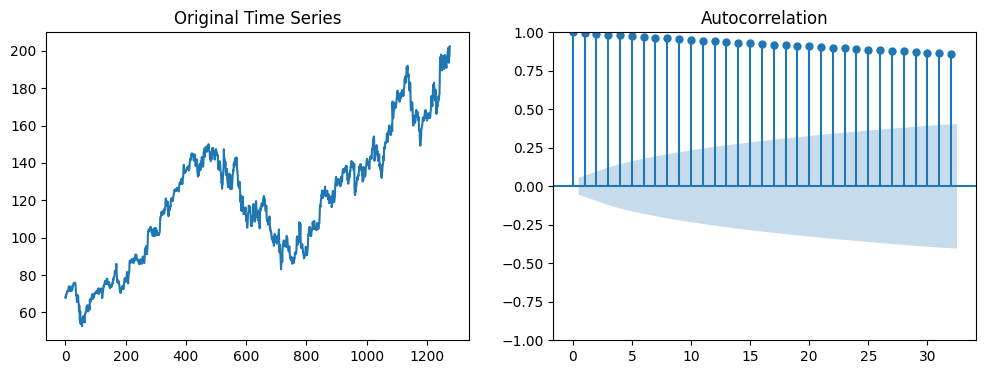

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(df['Close'])
ax1.set_title('Original Time Series')
plot_acf(df['Close'],ax=ax2);

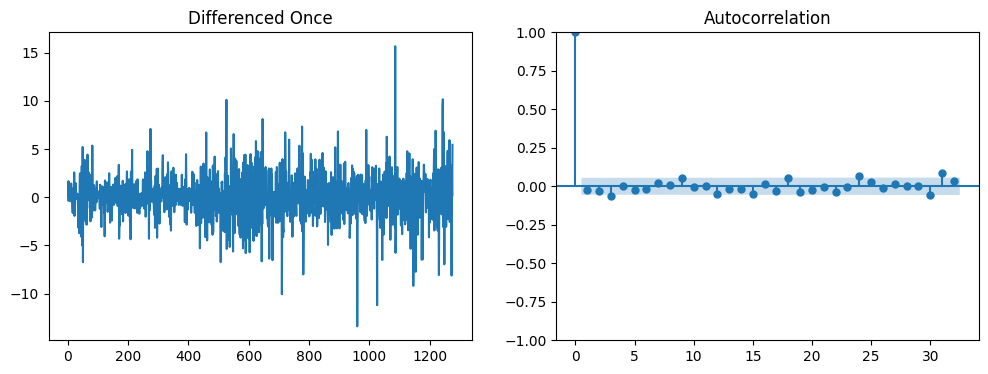

In [50]:
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);

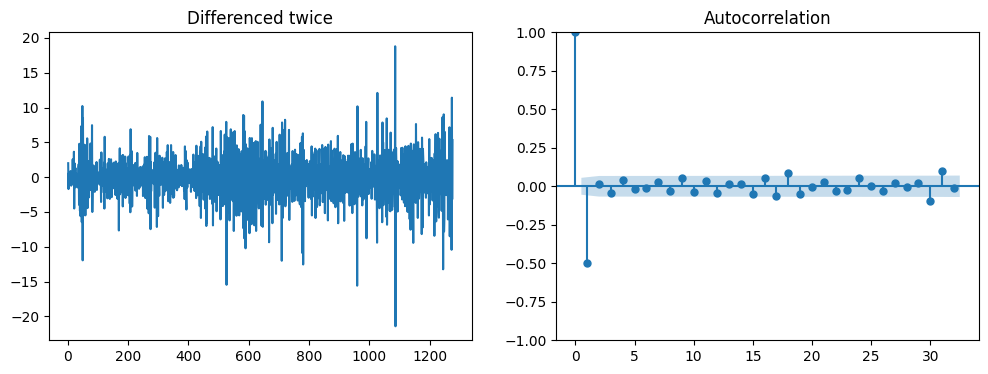

In [51]:
diff = df.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff,ax=ax2);

No bigger difference when differencing twice so selecting "order of differencing" as once and q = 8

p

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf

(0.0, 1.0)

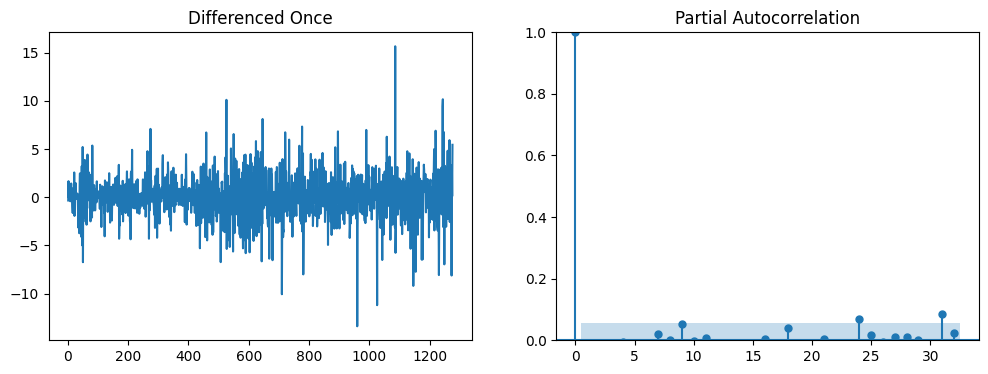

In [53]:
#p

diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_pacf(diff,ax=ax2);
ax2.set_ylim(0,1)

We observe PACF lag 31 based on the plot

In [70]:
from statsmodels.tsa.arima.model import ARIMA

#arima
model = ARIMA(df.Close, order=(31,1,8), trend='t')
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NameError: name 'forecast_steps' is not defined

In [58]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1277
Model:                ARIMA(31, 1, 8)   Log Likelihood               -2864.676
Date:                Sat, 29 Mar 2025   AIC                           5809.353
Time:                        01:05:46   BIC                           6015.412
Sample:                             0   HQIC                          5886.738
                               - 1277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0526      0.228      0.230      0.818      -0.395       0.500
ar.L2          0.1692      0.223      0.758      0.448      -0.268       0.606
ar.L3          0.3567      0.232      1.536      0.1

(array([4.79101451e-03, 1.15668779e-01, 4.20435967e-03, 9.77758063e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.77758063e-05]),
 array([-12.0436863 ,  -4.03469731,   3.97429168,  11.98328067,
         19.99226966,  28.00125866,  36.01024765,  44.01923664,
         52.02822563,  60.03721462,  68.04620361]),
 <BarContainer object of 10 artists>)

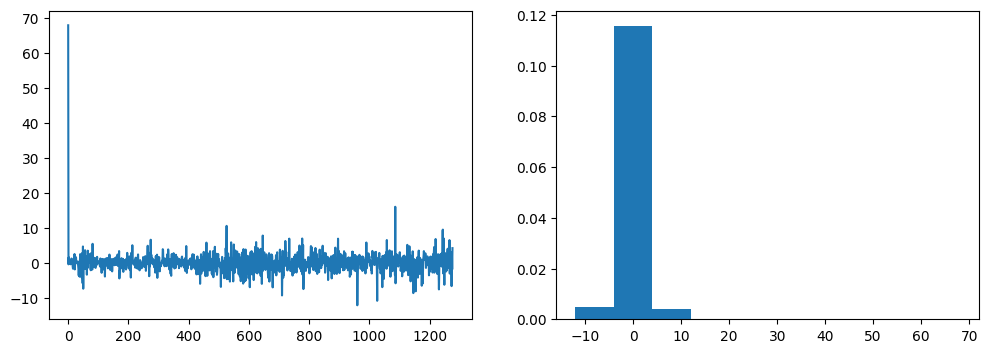

In [59]:
residuals = pd.DataFrame(model_fit.resid)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

In [63]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_arima_predict(model_fit, start, end, dynamic=False):
    """
    Plots the predictions from an ARIMA model.

    Args:
        model_fit: The fitted ARIMA model (statsmodels.tsa.arima.model.ARIMAResultsWrapper).
        start: The starting index for predictions.
        end: The ending index for predictions.
        dynamic: Whether to use dynamic predictions (default is False).
    """

    # Get the predictions
    predictions = model_fit.predict(start=start, end=end, dynamic=dynamic)

    # Get the original data (if available) for plotting
    original_data = model_fit.model.endog  # Access the original time series

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the original data if it exists
    if original_data is not None:
        plt.plot(original_data, label='Original Data')

    # Plot the predictions
    plt.plot(predictions, color='red', label='Predictions')

    plt.title('ARIMA Model Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage (assuming you have a fitted ARIMA model called 'model_fit'):
# plot_arima_predict(model_fit, start=1, end=60, dynamic=False)

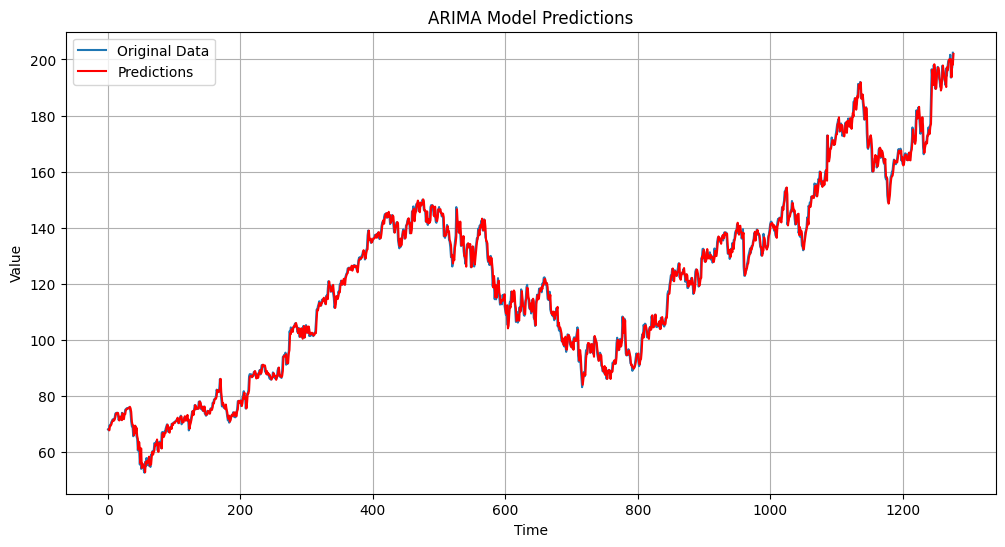

In [67]:
plot_arima_predict(model_fit, start=1, end=len(df.Close), dynamic=False)

Alternative lstm

In [72]:
hist = df

In [73]:
#Significant MA Lags
acf_coef = acf(hist['Close'], alpha=.05)
sig_acf = []
for i in range(1, len(acf_coef[0])):
    if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
        sig_acf.append(i)
    elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
        sig_acf.append(i)

sig_acf

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

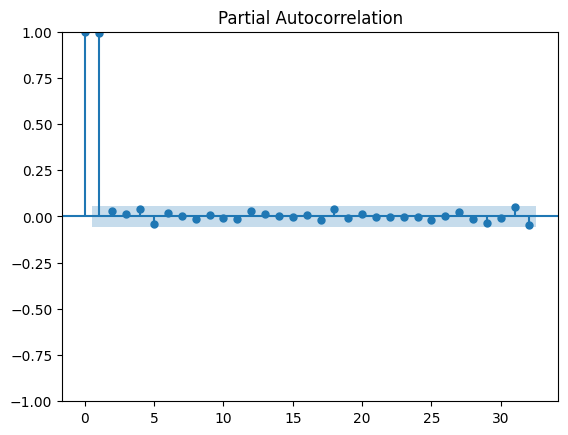

In [77]:
#Partial autocorrelation function plot:
sma.graphics.tsa.plot_pacf(hist['Close']);

In [78]:
#Significant AR lags:
pacf_coef = pacf(hist['Close'], alpha=.05)
sig_pacf = []
for i in range(1, len(pacf_coef[0])):
    if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
        sig_pacf.append(i)
    elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
        sig_pacf.append(i)

sig_pacf

[1, 31]

In [81]:
def get_arima_price(df, fact, forecast_steps):

    #MA Lags
    acf_coef = acf(df[fact], alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)

    #AR Lags
    pacf_coef = pacf(df[fact], alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)

    #Order of integration
    adf = adfuller(x=df[fact],
                  autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:
        order = 0
    else:
        order = 1

    #Trend indication
    if order == 1:
        trend = 't'
    else:
        trend = 'c'

    #ARIMA(p,d,q) Model
    model = ARIMA(endog = df[fact],
                  order = (sig_pacf, order, sig_acf),
                  trend = trend).fit()

    forecast = model.get_forecast(forecast_steps, alpha=0.05)

    predict = model.predict()

    return forecast.summary_frame(), model.summary(), predict

In [84]:
forecast, model_summary, predictions = get_arima_price(hist, 'Close', 20)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [88]:
predict = predictions

In [86]:
#Calculate residuals:
res = predictions[1:] - hist['Close'][1:]

#Perform Jarque-Bera Test
jb_stats = jarque_bera(res)

#If residuals are non-normal, fit student-t distribution:
if jb_stats[1] < 0.05:
  df, loc, scale = t.fit(res)

In [91]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist['Close'], mode = 'lines', name = 'Observed'))
fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis_title = 'Days',
    yaxis_title = 'Price $',
    title = f'{symbol} Stock Price'
)

fig.show()